<a href="https://colab.research.google.com/github/deepakri201/neurips_nlst_totalsegmentator/blob/main/NeurIPS_Datasets_and_Benchmarks_NLST_TotalSegmentator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NeurIPS Datasets and Benchmarks TotalSegmentator Analysis of NLST


---

This notebook provides the code that is needed to reproduce the figures in the paper submitted to NeurIPS Datasets and Benchmarks track. To reproduce, follow this link to obtain a GCP project id.



---




Deepa Krishnaswamy and Vamsi Krishna Thiriveedhi

Brigham and Women's Hospital

May 2024



---



In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [ ]:
import os
import sys
import time
import json
import subprocess
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sb
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

from collections import OrderedDict

import seaborn as sns

from pathlib import Path

import random

import collections
import scipy

In [ ]:
!pip install bokeh==2.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 48.6 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.8 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.


In [ ]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show, save
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

In [ ]:
import bokeh
bokeh.__version__

'2.4.3'

# Parameterization

In [ ]:
table_id = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa"

In [ ]:
# table_id = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status
# table_id_126k = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"
# table_id_10k = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status

# Functions

In [ ]:
def color_list_generator(df, col):
  """

  Create a list of colors per col given a dataframe

  Arguments:
    df    : dataframe to get data from
    col   : column to use to get unique treatments.

  Returns:
    colormap   : the colormap created
    colors     : the actual colors

  Inspired by creating colors for each treatment
  Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
  Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html

  """

  if (len(df[col].unique()))==1:
    colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
  elif (len(df[col].unique()))==2:
    colors = brewer["Dark2"][3][0:2]
  elif (len(df[col].unique()))>8:
    num_colors = len(df[col].unique())
    num_colormaps = np.int32(np.ceil(num_colors/8))
    colormap_chained = brewer["Dark2"][8]*num_colormaps
    colors = colormap_chained[0:num_colors]
  else:
    colors = brewer["Dark2"][len(df[col].unique())]

  # Create a map between treatment and color.
  colormap = {i: colors[k] for k,i in enumerate(df[col].unique())}

  # sort these according to the key
  colormap = collections.OrderedDict(sorted(colormap.items()))

  # Return a list of colors for each value that we will be looking at.
  return colormap, [colormap[x] for x in df[col]]

# Anatomical consistency

Here we analyze both the within-study consistency and the within-patient consistency of a subset of the segmentations.

## Within-study consistency

In [49]:
def create_bokeh_plot_within_study_include_num_series(df_plot, output_filename):
  """

      Inputs:
        df_plot   : a dataframe containing the columns: StudyInstanceUID, region, MAD_mL, num_series, viewer_url

      Outputs:
        creates a bokeh plot in the notebook
  """

  # output_notebook()

  df_plot['num_series'] = [str(f) for f in df_plot['num_series'].values]

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  # Get the structure to plot
  # df_plot_structure = seg_expert_vs_ai_df[seg_expert_vs_ai_df["structure_name"]==structure_name]

  # Create table where name of column is called 'distance'
  # df_plot = df_plot_structure.rename({column_name_distance: 'distance'}, axis=1)

  # sort the rows
  df_plot = df_plot.sort_values(by=['num_series']) # want alphabetical order

  # Get a color for each region
  colormap, colors = color_list_generator(df_plot, 'num_series')
  df_plot['colors'] = colors
  colormap_list_keys = list(colormap.keys())

  regions = colormap_list_keys
  colors = list(colormap.values())

  hover = HoverTool(tooltips=[
      ("(MAD_mL)", "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  cats = regions

  cats2 = []
  for c in range(0,len(cats)):
    cats2.append(cats[c])
    cats2.append(cats[c]+"_boxplot")
  regions = cats2

  colors2 = []
  for c in range(0,len(colors)):
    colors2.append(colors[c])
    colors2.append(colors[c])

  p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
            x_range=regions,
            title="MAD_mL")

  # l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
  # l1 = p1.circle(y='distance', x='model', source=df_plot, alpha=1, color='colors')
  # https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis
  def jitter(x):
      # return x + random.uniform(0, .5) -.25
      return x + random.uniform(0, 0.5) + 0.5
  type_ids = dict()
  for n in range(0,len(colormap_list_keys)):
    type_ids[colormap_list_keys[n]] = (n*2)
  df_plot['num_series_id'] = df_plot['num_series'].apply(lambda x:type_ids[x])
  df_plot['jitter_type'] = df_plot['num_series_id'].apply(lambda x: jitter(x))
  l1 = p1.circle(y='MAD_mL',x='jitter_type',source=df_plot, alpha=1, color='colors')

  legend = Legend(items=[LegendItem(label=dict(field="num_series"), renderers=[l1])])
  p1.add_layout(legend, 'below')

  ### Include the box plots ###
  # find the quartiles and IQR for each category

  df_plot2 = df_plot.copy(deep=True)
  df_plot2['num_series2'] = [f + '_boxplot' for f in df_plot['num_series'].values]

  # regions are in order we want
  category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
  df_plot2['num_series2'] = df_plot2['num_series2'].astype(category_experiment)

  # groups = df_plot.groupby('experiment')
  groups = df_plot2.groupby('num_series2')
  q1 = groups.quantile(q=0.25,numeric_only=True)
  q2 = groups.quantile(q=0.5, numeric_only=True)
  q3 = groups.quantile(q=0.75, numeric_only=True)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr

  # Form the source data to call vbar for upper and lower
  # boxes to be formed later.
  upper_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q2.MAD_mL,
      top=q3.MAD_mL,
      fill_color=colors2,
      legend=cats2
  ))

  lower_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q1.MAD_mL,
      top=q2.MAD_mL,
      fill_color=colors2
  ))

  # stems (Don't need colors of treatment)
  p1.segment(cats2, upper.MAD_mL, cats2, q3.MAD_mL, line_color="black")
  p1.segment(cats2, lower.MAD_mL, cats2, q1.MAD_mL, line_color="black")

  # Add the upper and lower quartiles
  l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

  # whiskers (almost-0 height rects simpler than segments)
  p1.rect(cats2, lower.MAD_mL, 0.2, 0.000001, line_color="black") # was 0.01
  p1.rect(cats2, upper.MAD_mL, 0.2, 0.000001, line_color="black")

  # Using the newer autogrouped syntax.
  # Grab a renderer, in this case upper quartile and then
  # create the legend explicitly.
  # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
  # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
  # p1.add_layout(legend, 'below')

  # Setup plot titles and such.
  # p1.title.text = str(column_name_distance) + '_' + str(structure_name)
  p1.xgrid.grid_line_color = None
  p1.ygrid.grid_line_color = "white"
  p1.grid.grid_line_width = 2
  p1.xaxis.major_label_text_font_size="0pt"
  p1.xaxis.major_label_orientation = np.pi/4
  p1.xaxis.axis_label = 'Num series per study'
  # p1.yaxis.axis_label = column_name_distance
  p1.legend.location = (100,10)

  p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
  p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

  url="@viewer_url"
  taptool = p1.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  show(p1)

  output_file(output_filename,mode='inline')

  return


In [50]:
def create_bokeh_plot_within_study(df_plot, output_filename):
  """ This function creates a bokeh plot for the particular structure and
      distance metric

      Inputs:
        df_plot   : a dataframe containing the columns: StudyInstanceUID, region, MAD_mL, viewer_url

      Outputs:
        creates a bokeh plot in the notebook
  """

  # output_notebook()

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  # Get the structure to plot
  # df_plot_structure = seg_expert_vs_ai_df[seg_expert_vs_ai_df["structure_name"]==structure_name]

  # Create table where name of column is called 'distance'
  # df_plot = df_plot_structure.rename({column_name_distance: 'distance'}, axis=1)

  # sort the rows
  df_plot = df_plot.sort_values(by=['region_and_laterality']) # want alphabetical order

  # Get a color for each region
  colormap, colors = color_list_generator(df_plot, 'region_and_laterality')
  df_plot['colors'] = colors
  colormap_list_keys = list(colormap.keys())

  regions = colormap_list_keys
  colors = list(colormap.values())

  hover = HoverTool(tooltips=[
      ("(MAD_mL)", "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  cats = regions

  cats2 = []
  for c in range(0,len(cats)):
    cats2.append(cats[c])
    cats2.append(cats[c]+"_boxplot")
  regions = cats2

  colors2 = []
  for c in range(0,len(colors)):
    colors2.append(colors[c])
    colors2.append(colors[c])

  p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
            x_range=regions,
            title="MAD_mL")

  # l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
  # l1 = p1.circle(y='distance', x='model', source=df_plot, alpha=1, color='colors')
  # https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis
  def jitter(x):
      # return x + random.uniform(0, .5) -.25
      return x + random.uniform(0, 0.5) + 0.5
  type_ids = dict()
  for n in range(0,len(colormap_list_keys)):
    type_ids[colormap_list_keys[n]] = (n*2)
  df_plot['region_and_laterality_id'] = df_plot['region_and_laterality'].apply(lambda x:type_ids[x])
  df_plot['jitter_type'] = df_plot['region_and_laterality_id'].apply(lambda x: jitter(x))
  l1 = p1.circle(y='MAD_mL',x='jitter_type',source=df_plot, alpha=1, color='colors')

  legend = Legend(items=[LegendItem(label=dict(field="region_and_laterality"), renderers=[l1])])
  p1.add_layout(legend, 'below')

  ### Include the box plots ###
  # find the quartiles and IQR for each category

  df_plot2 = df_plot.copy(deep=True)
  df_plot2['region_and_laterality2'] = [f + '_boxplot' for f in df_plot['region_and_laterality'].values]

  # regions are in order we want
  category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
  df_plot2['region_and_laterality2'] = df_plot2['region_and_laterality2'].astype(category_experiment)

  # groups = df_plot.groupby('experiment')
  groups = df_plot2.groupby('region_and_laterality2')
  q1 = groups.quantile(q=0.25,numeric_only=True)
  q2 = groups.quantile(q=0.5, numeric_only=True)
  q3 = groups.quantile(q=0.75, numeric_only=True)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr

  # Form the source data to call vbar for upper and lower
  # boxes to be formed later.
  upper_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q2.MAD_mL,
      top=q3.MAD_mL,
      fill_color=colors2,
      legend=cats2
  ))

  lower_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q1.MAD_mL,
      top=q2.MAD_mL,
      fill_color=colors2
  ))

  # stems (Don't need colors of treatment)
  p1.segment(cats2, upper.MAD_mL, cats2, q3.MAD_mL, line_color="black")
  p1.segment(cats2, lower.MAD_mL, cats2, q1.MAD_mL, line_color="black")

  # Add the upper and lower quartiles
  l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

  # whiskers (almost-0 height rects simpler than segments)
  p1.rect(cats2, lower.MAD_mL, 0.2, 0.000001, line_color="black") # was 0.01
  p1.rect(cats2, upper.MAD_mL, 0.2, 0.000001, line_color="black")

  # Using the newer autogrouped syntax.
  # Grab a renderer, in this case upper quartile and then
  # create the legend explicitly.
  # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
  # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
  # p1.add_layout(legend, 'below')

  # Setup plot titles and such.
  # p1.title.text = str(column_name_distance) + '_' + str(structure_name)
  p1.xgrid.grid_line_color = None
  p1.ygrid.grid_line_color = "white"
  p1.grid.grid_line_width = 2
  p1.xaxis.major_label_text_font_size="0pt"
  p1.xaxis.major_label_orientation = np.pi/4
  p1.xaxis.axis_label = 'Num series per study'
  # p1.yaxis.axis_label = column_name_distance
  p1.legend.location = (100,10)

  p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
  p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

  url="@viewer_url"
  taptool = p1.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  show(p1)

  output_file(output_filename,mode='inline')

  return


In [ ]:
def query_for_within_study_with_laterality(region, laterality, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""

    SELECT
      DISTINCT(clinical_table.sourceSegmentedSeriesUID),
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID,
      age,
      gender,
      Value,
      SeriesNumber,
      ViewerUrl
    FROM
      `{table_id}` as clinical_table
    JOIN
      `idc-external-025.terra.segmentation_completeness_table` as segmentation_completeness
    ON
      clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
      # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND
      clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
    WHERE
      findingSite.CodeMeaning = @region AND
      lateralityModifier.CodeMeaning = @laterality AND
      Quantity.CodeMeaning = @feature AND
      segmentation_completeness_check = 'may_be_segmented_fully'
    ORDER BY
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID;

    """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("laterality", "STRING", laterality),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

def query_for_within_study_no_laterality(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""

    SELECT
      DISTINCT(clinical_table.sourceSegmentedSeriesUID),
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID,
      age,
      gender,
      Value,
      SeriesNumber,
      ViewerUrl
    FROM
      `{table_id}` as clinical_table
    JOIN
      `idc-external-025.terra.segmentation_completeness_table` as segmentation_completeness
    ON
      clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
      # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND
      clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
    WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature AND
      segmentation_completeness_check = 'may_be_segmented_fully'
    ORDER BY
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID;

    """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

In [38]:
# region_list = ["Lower lobe of lung", "Lower lobe of lung", "Spleen", "Liver", "L1 vertebra", "T7 vertebra"]
# laterality_list = ["Left", "Right", None, None, None, None]
region_list = ["Spleen"]
laterality_list = [None]
feature = "Volume"
table_id = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"

In [39]:
num_regions = len(region_list)

df_plot_mad_all = pd.DataFrame()

for n in range(0,num_regions):

  region = region_list[n]
  laterality = laterality_list[n]
  print('***** region: ' + str(region) + ', laterality: ' + str(laterality) + ' *****')

  if (laterality is None):
    df_plot = query_for_within_study_no_laterality(region, feature, table_id, project_name)
  else:
    df_plot = query_for_within_study_with_laterality(region, laterality, feature, table_id, project_name)

  # For each study, group by and get the median
  median_volumes = df_plot.groupby('StudyInstanceUID')['Value'].median()
  median_volumes_df = median_volumes.reset_index()
  median_volumes_df.columns = ['StudyInstanceUID', 'Median']

  # Also get the count of the number of series per study
  num_series = df_plot.groupby('StudyInstanceUID')['sourceSegmentedSeriesUID'].count()
  num_series_df = num_series.reset_index()
  num_series_df.columns = ['StudyInstanceUID', 'num_series']

  # Now add the median value as a column to the original dataframe
  df_plot2 = df_plot.merge(median_volumes_df, on='StudyInstanceUID', how='inner')

  # Now add the number of series as a column to the dataframe
  df_plot2 = df_plot2.merge(num_series_df, on='StudyInstanceUID', how='inner')

  # Set the datatype
  df_plot2['Median'] = [np.float32(f) for f in df_plot2['Median'].values]
  df_plot2['Value'] = [np.float32(f) for f in df_plot2['Value'].values]

  # Now calculate the absolute difference between each value and the median
  df_plot2['Median_minus_Value'] = abs(df_plot2['Median'].values - df_plot2['Value'].values)

  # Now get the median value of the absolute differences
  median_volumes2 = df_plot2.groupby('StudyInstanceUID')['Median_minus_Value'].median()
  median_volumes_df2 = median_volumes2.reset_index()
  median_volumes_df2.columns = ['StudyInstanceUID', 'MAD']

  # Now add to final dataframe
  df_plot_mad = df_plot2.merge(median_volumes_df2, on='StudyInstanceUID', how='inner')

  # Divide by 1000.00 to get mL values
  df_plot_mad['MAD_mL'] = df_plot_mad['MAD'].values / 1000.00

  # Now just keep one row per study
  df_plot_mad = df_plot_mad.drop_duplicates(subset=['StudyInstanceUID'], keep='first', inplace=False, ignore_index=False)

  # Now just keep a subset of the columns
  df_plot_mad = df_plot_mad[['StudyInstanceUID', 'MAD_mL', 'num_series']]

  # Redo the viewer_url
  df_plot_mad['viewer_url'] = [os.path.join('https://viewer.imaging.datacommons.cancer.gov/viewer',f) for f in df_plot_mad['StudyInstanceUID'].values]

  # df_plot_mad

  # Now create a column with the region value and laterality
  df_plot_mad['region'] = [region] * len(df_plot_mad)
  df_plot_mad['laterality'] = [laterality] * len(df_plot_mad)
  # Combine
  if (laterality is None):
    df_plot_mad['region_and_laterality'] = region
  else:
    df_plot_mad['region_and_laterality'] = region + ' ' + laterality

  # Concatenate with the df_plot_mad_all dataframe
  df_plot_mad_all = pd.concat([df_plot_mad_all, df_plot_mad])


***** region: Spleen, laterality: None *****


In [ ]:
set(df_plot_mad_all['region_and_laterality'].values)

{'L1 vertebra',
 'Liver',
 'Lower lobe of lung Left',
 'Lower lobe of lung Right',
 'Spleen',
 'T7 vertebra'}

In [51]:
# Now create a bokeh plot per region

region_and_laterality_list = list(set(df_plot_mad_all['region_and_laterality'].values))

output_directory = "/content/bokeh_plots_within_study"
if not os.path.isdir(output_directory):
  os.mkdir(output_directory)

for n in range(0,len(region_list)):
  df_plot = df_plot_mad_all[df_plot_mad_all['region_and_laterality']==region_and_laterality_list[n]]
  output_filename = os.path.join(output_directory, region_and_laterality_list[n].replace(" ", "_") + ".html")
  print(output_filename)
  # create_bokeh_plot_within_study(df_plot, output_filename)
  create_bokeh_plot_within_study_include_num_series(df_plot, output_filename)

/content/bokeh_plots_within_study/Spleen.html


## IGNORE old Within-study

In [ ]:
region = "Spleen"
df_plot = query_for_within_study(region, features, table_id, project_name)

In [ ]:
# For each study, group by and get the median
median_volumes = df_plot.groupby('StudyInstanceUID')['Value'].median()
median_volumes_df = median_volumes.reset_index()
median_volumes_df.columns = ['StudyInstanceUID', 'Median']

# Also get the count of the number of series per study
num_series = df_plot.groupby('StudyInstanceUID')['sourceSegmentedSeriesUID'].count()
num_series_df = num_series.reset_index()
num_series_df.columns = ['StudyInstanceUID', 'num_series']

# Now add the median value as a column to the original dataframe
df_plot2 = df_plot.merge(median_volumes_df, on='StudyInstanceUID', how='inner')

# Now add the number of series as a column to the dataframe
df_plot2 = df_plot2.merge(num_series_df, on='StudyInstanceUID', how='inner')

# Set the datatype
df_plot2['Median'] = [np.float32(f) for f in df_plot2['Median'].values]
df_plot2['Value'] = [np.float32(f) for f in df_plot2['Value'].values]

# Now calculate the absolute difference between each value and the median
df_plot2['Median_minus_Value'] = abs(df_plot2['Median'].values - df_plot2['Value'].values)

# Now get the median value of the absolute differences
median_volumes2 = df_plot2.groupby('StudyInstanceUID')['Median_minus_Value'].median()
median_volumes_df2 = median_volumes2.reset_index()
median_volumes_df2.columns = ['StudyInstanceUID', 'MAD']

# Now add to final dataframe
df_plot_mad = df_plot2.merge(median_volumes_df2, on='StudyInstanceUID', how='inner')

# Divide by 1000.00 to get mL values
df_plot_mad['MAD_mL'] = df_plot_mad['MAD'].values / 1000.00

# Now just keep one row per study
df_plot_mad = df_plot_mad.drop_duplicates(subset=['StudyInstanceUID'], keep='first', inplace=False, ignore_index=False)

# Now just keep a subset of the columns
df_plot_mad = df_plot_mad[['StudyInstanceUID', 'MAD_mL', 'num_series']]

# Redo the viewer_url
df_plot_mad['viewer_url'] = [os.path.join('https://viewer.imaging.datacommons.cancer.gov/viewer',f) for f in df_plot_mad['StudyInstanceUID'].values]

df_plot_mad


StudyInstanceUID    MAD_mL  \
0      1.2.840.113654.2.55.89933508291954731667890414...  2.156063   
2      1.2.840.113654.2.55.17414483492421841421367735...  0.271688   
4      1.2.840.113654.2.55.31488288109310049864837507...  6.364125   
6      1.2.840.113654.2.55.32767037256259970220543212...  2.634187   
8      1.2.840.113654.2.55.10251457513072085864761297...  0.000000   
...                                                  ...       ...   
48625  1.3.6.1.4.1.14519.5.2.1.7009.9004.213336499035...  1.983375   
48627  1.3.6.1.4.1.14519.5.2.1.7009.9004.150167216460...  0.000000   
48628  1.3.6.1.4.1.14519.5.2.1.7009.9004.221706423020...  0.000000   
48629  1.3.6.1.4.1.14519.5.2.1.7009.9004.166630377919...  1.285313   
48631  1.3.6.1.4.1.14519.5.2.1.7009.9004.307431826785...  0.000000   

       num_series                                         viewer_url  
0               2  https://viewer.imaging.datacommons.cancer.gov/...  
2               2  https://viewer.imaging.datacommons.cancer.gov/...  
4               2  https://viewer.imaging.datacommons.cancer.gov/...  
6               2  https://viewer.imaging.datacommons.cancer.gov/...  
8               1  https://viewer.imaging.datacommons.cancer.gov/...  
...           ...                                                ...  
48625           2  https://viewer.imaging.datacommons.cancer.gov/...  
48627           1  https://viewer.imaging.datacommons.cancer.gov/...  
48628           1  https://viewer.imaging.datacommons.cancer.gov/...  
48629           2  https://viewer.imaging.datacommons.cancer.gov/...  
48631           1  https://viewer.imaging.datacommons.cancer.gov/...  

[28615 rows x 4 columns]

<Axes: ylabel='MAD_mL'>

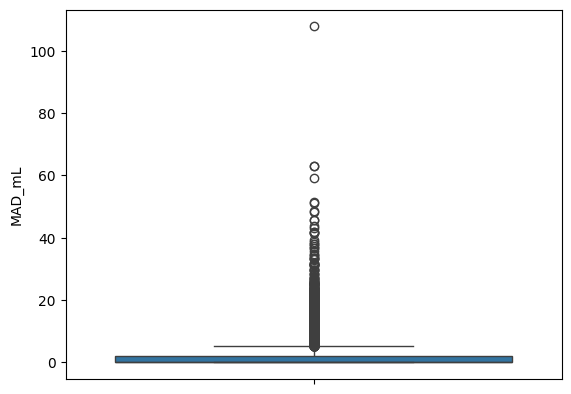

In [ ]:
# Now plot these values

sns.boxplot(data=df_plot_mad, y="MAD_mL")


## Within-patient consistency

# Population study

Here we do a comparison of the vertebrae volume to what is found in the literature.